In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
data = pd.read_csv(r'C:\Users\admin\Downloads\english - to marathi.csv')
data['English']

0                                                       Go.
1                                                       Go.
2                                                       Go.
3                                                       Go.
4                                                       Hi.
                                ...                        
118958    There are four main causes of alcohol-related ...
118959    There are mothers and fathers who will lie awa...
118960    A carbon footprint is the amount of carbon dio...
118961    Since there are usually multiple websites on a...
118962    If you want to sound like a native speaker, yo...
Name: English, Length: 118963, dtype: object

In [42]:
english_list = data['English'].to_list()
marathi_list = data['Marathi'].to_list()

In [43]:
english_list

['Go.',
 'Go.',
 'Go.',
 'Go.',
 'Hi.',
 'Run!',
 'Run.',
 'Fire!',
 'Fire!',
 'Fire!',
 'Help!',
 'Help!',
 'Help!',
 'Jump!',
 'Jump.',
 'Stop!',
 'Stop!',
 'Stop!',
 'Wait!',
 'Wait.',
 'Go on.',
 'Go on.',
 'Hello!',
 'I ran.',
 'I ran.',
 'I try.',
 'I won!',
 'Oh no!',
 'Relax.',
 'Smile.',
 'Attack!',
 'Attack!',
 'Get up.',
 'Go now.',
 'Got it!',
 'Got it?',
 'Got it?',
 'He ran.',
 'Hop in.',
 'Hug me.',
 'I fell.',
 'I know.',
 'I left.',
 'I lied.',
 'I lost.',
 'I quit.',
 'I quit.',
 'I work.',
 "I'm 19.",
 "I'm up.",
 'Listen.',
 'Listen.',
 'Listen.',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'No way!',
 'Really?',
 'Really?',
 'Thanks.',
 'Thanks.',
 'Try it.',
 'We try.',
 'We won.',
 'Why me?',
 'Ask Tom.',
 'Awesome!',
 'Be calm.',
 'Be cool.',
 'Be fair.',
 'Be kind.',
 'Be nice.',
 'Beat it.',
 'Call me.',
 'Call me.',
 'Call me.',
 'Call us.',
 'Come in.',
 'Come in.',
 'Come in.',
 'Come on!',
 '

In [44]:
marathi_list

['जा.',
 'जा.',
 'जा.',
 'जा.',
 'हाय.',
 'धावा!',
 'धावा.',
 'आग!',
 'आग!',
 'आग!',
 'मदत!',
 'मदत!',
 'मदत!',
 'उडी!',
 'उडी.',
 'थांबा!',
 'थांबा!',
 'थांबा!',
 'थांबा!',
 'थांबा.',
 'पुढे जा.',
 'पुढे जा.',
 'नमस्कार!',
 'मी धावलो.',
 'मी धावलो.',
 'मी प्रयत्न करतो.',
 'मी जिंकले!',
 'अरे नाही!',
 'आराम.',
 'हसा.',
 'हल्ला!',
 'हल्ला!',
 'उठ.',
 'जा आता.',
 'समजले!',
 'समजले?',
 'समजले?',
 'तो धावला.',
 'आत जा.',
 'मला मिठी मार.',
 'मी पडलो.',
 'मला माहित आहे.',
 'मी निघालो.',
 'मी खोट बोलले.',
 'मी हरलो.',
 'मी सोडले.',
 'मी सोडले.',
 'मी काम करतो.',
 'मी १९ वर्षांचा आहे.',
 'मी उठलो.',
 'ऐका.',
 'ऐका.',
 'ऐका.',
 'मार्ग नाही!',
 'मार्ग नाही!',
 'मार्ग नाही!',
 'मार्ग नाही!',
 'मार्ग नाही!',
 'मार्ग नाही!',
 'मार्ग नाही!',
 'मार्ग नाही!',
 'मार्ग नाही!',
 'मार्ग नाही!',
 'खरंच?',
 'खरंच?',
 'धन्यवाद.',
 'धन्यवाद.',
 'हे करून पहा.',
 'आम्ही प्रयत्न करतो.',
 'आम्ही जिंकलो.',
 'मलाच का?',
 'टॉमला विचारा.',
 'अप्रतिम!',
 'शांत रहा.',
 'शांत राहा.',
 'निष्पक्ष व्हा.',
 'दया कर.',
 'चां

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(english_list)
english_seq = english_tokenizer.texts_to_sequences(english_list)


marathi_tokenizer = Tokenizer()
marathi_tokenizer.fit_on_texts(marathi_list)
marathi_seq = marathi_tokenizer.texts_to_sequences(marathi_list)


vocabsize_eng = len(english_tokenizer.word_index)+1
vocabsize_mar = len(marathi_tokenizer.word_index)+1

maxlen = max(len(sen) for sen in  english_seq + marathi_seq )


padding_english = pad_sequences(english_seq,maxlen=maxlen,padding='post')
padding_marathi = pad_sequences(marathi_seq,maxlen=maxlen,padding='post')

In [46]:
padding_english.shape,padding_marathi.shape

((118963, 47), (118963, 47))

In [47]:
padding_english[0],padding_marathi[0]

(array([40,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([278,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]))

**Bahdanau Attention Mechnisim**

In [64]:
from tensorflow.keras.layers import LSTM,Embedding,Input,Dense,Dot,Concatenate,Activation,Dropout,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

embedding_dim = 256
units = 512

# Encoder
encoder_input = Input(shape = (maxlen,))

# Embedding Layers
encoder_emb = Embedding(input_dim = vocabsize_eng,output_dim = embedding_dim)(encoder_input)

# Adding the Dropout Layer after the Embeddings
encoder_emd = Dropout(0.3)(encoder_emb)


# And Here we are applying the dropout and l2 regularizer to control the overfitting problem


# For imporving the Accuracy the we need do hyper parameter tuning like increasing or decreasing the the LSTM layers ,
# Instead of LSTM if data is small apply GRU Network
# Reverse the Encoder words so that the first letters are having more relational and last words
# Use the Bidirectional Networks so that we can go from first and from last and at each cell have information of all the cells..

# 1. LSTM Layer
encoder_lstm1,state_h1,state_c1 = LSTM(units,return_state = True,return_sequences= True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)(encoder_emb)

"""
Example = Bidirectional(LSTM(units,return_state = True,return_sequences= True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3))(encoder_emb)

of Bidirectional LSTM

"""


# 2. LSTM Layer
encoder_lstm2,state_h2,state_c2 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)(encoder_lstm1)

#3. LSTM Layer
encoder_lstm3,state_h3,state_c3 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)(encoder_lstm2)

#4. LSTM Layer
encoder_lstm4,state_h4,state_c4 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)(encoder_lstm3)

encoder_output = encoder_lstm4
encoder_states = [state_h4,state_c4]


""""
The Attention Mechanisim that which are we are using that Bahdanau Attention Mechanisim that which take the FNN(FeedForward Neural Network)
as the Function to calculate the importance of the word by assiging the weightage of the word which take it as 'A' where A = fun(yt,st-1)
that where 'A' is the Alpha value and yt :- enocder output  and st-1 is previous word that predicted by the decoder (this is useful to find 
how the current encoder input to predict that current decoder word) like for example my name is Revanth Kumar Kurra if you convert this into
my mother toung telugu we say "na peru Revanth Kumar kurra" if we send english word to enocoder and it trianed and by now the decoder model prediceted
this sentence "na peru Revanth" and encoder will check each work because we dont the order of the words and this may come first or at last so we check
each word in encoder and now if go feather my decoder need predict the word "kumar" but it is in "name" word in encoder so we need to predict the "kumar"
so it will check the word "name" but the previous word predicted by Decoder is "Revanth" so the next word would be "kumar" to find this relation the previous 
word in the decoder will sent and we use the function is FNN(it is a universal function that which can identify the any relation by good and proper data)
so we find that the word is important or not.

"""





class BahdanauAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttentionLayer, self).__init__()
        self.W1 = Dense(units)  
        self.W2 = Dense(units)  
        self.V = Dense(1)  
    def call(self, decoder_output, encoder_output):
        # Add time dimension to decoder output (query) to match encoder output (values)
        decoder_output = tf.expand_dims(decoder_output, 1)  
        
        # Calculate the score
        score = self.V(tf.nn.tanh(self.W1(decoder_output) + self.W2(encoder_output)))
        
        # Apply softmax to get the attention weights
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attention_weights


bahdanau_attention_mechanism = BahdanauAttentionLayer(units = units)

# Decoder
decoder_input = Input(shape =(maxlen,))

# Embedding 
decoder_emb = Embedding(input_dim = vocabsize_mar,output_dim = embedding_dim)(decoder_input)

decoder_emb = Dropout(0.3)(decoder_emb)

# here also same we are applying the dropout and the l2 regularizer

# 1st LSTM Layer
decoder_lstm1 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)
decoder_output1,_,_ = decoder_lstm1(decoder_emb,initial_state = encoder_states)

# Calculating the Context Vector for 1st LSTM 
context_Vector1,attention_weight1 = bahdanau_attention_mechanism(decoder_output1,encoder_output)
decoder_com_cot1 = Concatenate(axis=-1)([decoder_output1,context_Vector1])


# 2nd LSTM Layer
decoder_lstm2 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)
decoder_output2,_,_ = decoder_lstm2(decoder_output1)

# Calculating the Context Vector for the 2nd LSTM
context_Vector2,attention_weight2 = bahdanau_attention_mechanism(decoder_output2,encoder_output)
decoder_com_cot2 = Concatenate(axis=-1)([decoder_output2,context_Vector2])

# 3rd LSTM Layer
decoder_lstm3 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)
decoder_output3,_,_ = decoder_lstm3(decoder_output2)

# Calculating the Context Vector for the 3rd LSTM
context_Vector3,attention_weight3 = bahdanau_attention_mechanism(decoder_output3,encoder_output)
decoder_com_cot3  = Concatenate(axis=-1)([decoder_output3,context_Vector3])

#4th LSTM Layer
decoder_lstm4 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)
decoder_output4,_,_ = decoder_lstm4(decoder_output3)

# Calculating the Context vector for the 4th LSTM
context_Vector4,attention_weight4 = bahdanau_attention_mechanism(decoder_output4,encoder_output)
decoder_com_cot4 = Concatenate(axis=-1)([decoder_output4,context_Vector4])



# Decoder Dense 
decoder_dense = Dense(vocabsize_mar,activation = 'softmax')
output = decoder_dense(decoder_com_cot4)

model = Model([encoder_input,decoder_input],output)

# Here we applying gradient cliping to overcome exploding gradient problem so we are using this

optimizer = Adam(learning_rate = 0.001,clipnorm = 0.7)

model.compile(optimizer = optimizer,loss=  'sparse_categorical_crossentropy',metrics = ['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 47, 256)   │  3,462,400 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ [(None, 47, 512), │  1,574,912 │ embedding_8[0][0] │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_32[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 47, 256)   │  7,582,208 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_33[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 47, 256)   │          0 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_34[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ [(None, 47, 512), │  1,574,912 │ dropout_7[0][0],  │
│                     │ (None, 512),      │            │ lstm_35[0][1],    │
│                     │ (None, 512)]      │            │ lstm_35[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_36[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_37[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_38[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ [(None, 47, 512), │    525,825 │ lstm_39[0][0],    │
│ (BahdanauAttention… │ (None, None, 47,  │            │ lstm_35[0][0]     │
│                     │ 1)]               │            │                 

 Total params: 57,673,907 (220.01 MB)

 Trainable params: 57,673,907 (220.01 MB)

 Non-trainable params: 0 (0.00 B)

**Luong Attention Mechanisim**

In [48]:
from tensorflow.keras.layers import LSTM,Embedding,Input,Dense,Dot,Concatenate,Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


embedding_dim = 256
units = 512

# And Here we are applying the dropout and l2 regularizer to control the overfitting problem


# For imporving the Accuracy the we need do hyper parameter tuning like increasing or decreasing the the LSTM layers ,
# Instead of LSTM if data is small apply GRU Network
# Reverse the Encoder words so that the first letters are having more relational and last words
# Use the Bidirectional Networks so that we can go from first and from last and at each cell have information of all the cells..
# Encoder
encoder_input = Input(shape = (maxlen,))

# Embedding Layers
encoder_emb = Embedding(input_dim = vocabsize_eng,output_dim = embedding_dim)(encoder_input)
encoder_emb = Dropout(0.3)(encoder_emb)

"""
Example = Bidirectional(LSTM(units,return_state = True,return_sequences= True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3))(encoder_emb)

of Bidirectional LSTM

"""

# 1. LSTM Layer
encoder_lstm1,state_h1,state_c1 = LSTM(units,return_state = True,return_sequences= True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)(encoder_emb)

# 2. LSTM Layer
encoder_lstm2,state_h2,state_c2 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)(encoder_lstm1)

#3. LSTM Layer
encoder_lstm3,state_h3,state_c3 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)(encoder_lstm2)

#4. LSTM Layer
encoder_lstm4,state_h4,state_c4 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)(encoder_lstm3)

encoder_output = encoder_lstm4
encoder_states = [state_h4,state_c4]

"""
As Same as the Bhadanu attention machanisim the Luong attetion Mechanism is also but where in A(st,yt) where here it use the dot product of the two yt and st
and making it very simpilar instead of using the  FNN and huge time taking so it easy and less time taking where here it is taking si instead of si-1 because 
the word in si is having more updated data.

"""



def luong_attention(decoder_output,encoder_output):

    # Applying the Dot product for the encoder input and the output
    attention_score = Dot(axes = [2,2])([encoder_output,decoder_output])

    attention_weight = Activation('softmax')(attention_score)
    
    context_vector = Dot(axes =[2,1])([attention_weight,encoder_output])

    return context_vector,attention_weight


# Decoder
decoder_input = Input(shape =(maxlen,))

# Embedding 
decoder_emb = Embedding(input_dim = vocabsize_mar,output_dim = embedding_dim)(decoder_input)
decoder_emb = Dropout(0.3)(decoder_emb)

# 1st LSTM Layer
decoder_lstm1 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)
decoder_output1,_,_ = decoder_lstm1(decoder_emb,initial_state = encoder_states)

# Calculating the Context Vector for 1st LSTM 
context_Vector1,attention_weight1 = luong_attention(decoder_output1,encoder_output)
decoder_com_cot1 = Concatenate(axis=-1)([decoder_output1,context_Vector1])


# 2nd LSTM Layer
decoder_lstm2 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)
decoder_output2,_,_ = decoder_lstm2(decoder_output1)

# Calculating the Context Vector for the 2nd LSTM
context_Vector2,attention_weight2 = luong_attention(decoder_output2,encoder_output)
decoder_com_cot2 = Concatenate(axis=-1)([decoder_output2,context_Vector2])

# 3rd LSTM Layer
decoder_lstm3 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)
decoder_output3,_,_ = decoder_lstm3(decoder_output2)

# Calculating the Context Vector for the 3rd LSTM
context_Vector3,attention_weight3 = luong_attention(decoder_output3,encoder_output)
decoder_com_cot3  = Concatenate(axis=-1)([decoder_output3,context_Vector3])

#4th LSTM Layer
decoder_lstm4 = LSTM(units,return_state = True,return_sequences = True,kernel_regularizer=l2(0.2),recurrent_dropout=0.3)
decoder_output4,_,_ = decoder_lstm4(decoder_output3)

# Calculating the Context vector for the 4th LSTM
context_Vector4,attention_weight4 = luong_attention(decoder_output4,encoder_output)
decoder_com_cot4 = Concatenate(axis=-1)([decoder_output4,context_Vector4])



# Decoder Dense 
decoder_dense = Dense(vocabsize_mar,activation = 'softmax')
output = decoder_dense(decoder_com_cot4)

model = Model([encoder_input,decoder_input],output)

optimizer = Adam(learning_rate = 0.0001,clipnorm = 0.7)

model.compile(optimizer = optimizer,loss=  'sparse_categorical_crossentropy',metrics = ['accuracy'])


earlystoping = EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=1e-6)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 47, 256)   │  3,462,400 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 47, 256)   │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ [(None, 47, 512), │  1,574,912 │ dropout_4[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_24[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 47, 256)   │  7,582,208 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_25[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 47, 256)   │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_26[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ [(None, 47, 512), │  1,574,912 │ dropout_5[0][0],  │
│                     │ (None, 512),      │            │ lstm_27[0][1],    │
│                     │ (None, 512)]      │            │ lstm_27[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_28[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_29[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ [(None, 47, 512), │  2,099,200 │ lstm_30[0][0]     │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_30 (Dot)        │ (None, 47, 47)    │          0 │ lstm_27[0][0],  

 Total params: 57,148,082 (218.00 MB)

 Trainable params: 57,148,082 (218.00 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(padding_english,padding_marathi,random_state=7,test_size=0.1)

In [50]:
X_train[0],y_train[0]

(array([ 945,  420, 1446,  350,    1,  514,   10,    1, 2005,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]),
 array([3294, 4048, 1001,  711, 1108,   38,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]))

In [51]:

model_history = model.fit([X_train,X_train],y_train,batch_size=35,epochs=7,validation_data=([X_test,X_test],y_test),callbacks=[earlystoping,reduce_lr])

Epoch 1/7
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 11487s 4s/step - accuracy: 0.8801 - loss: 183.1679 - val_accuracy: 0.8850 - val_loss: 0.9107 - learning_rate: 1.0000e-04
Epoch 2/7
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 11374s 4s/step - accuracy: 0.8849 - loss: 0.9061 - val_accuracy: 0.8858 - val_loss: 0.9049 - learning_rate: 1.0000e-04
Epoch 3/7
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 11311s 4s/step - accuracy: 0.8851 - loss: 0.8980 - val_accuracy: 0.8858 - val_loss: 0.9024 - learning_rate: 1.0000e-04
Epoch 4/7
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 10979s 4s/step - accuracy: 0.8847 - loss: 0.8954 - val_accuracy: 0.8858 - val_loss: 0.9006 - learning_rate: 1.0000e-04
Epoch 5/7
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 9942s 3s/step - accuracy: 0.8850 - loss: 0.8910 - val_accuracy: 0.8858 - val_loss: 0.8990 - learning_rate: 1.0000e-04
Epoch 6/7
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 6629s 2s/step - accuracy: 0.8852 - loss: 0.8853 - val_accuracy: 0.8858 - val_loss: 0.8985 - learning_rate: 1.0000e-04
Epoch 7/7
3060/3060 ━━━━━━━━━━━━━━━━━━━━

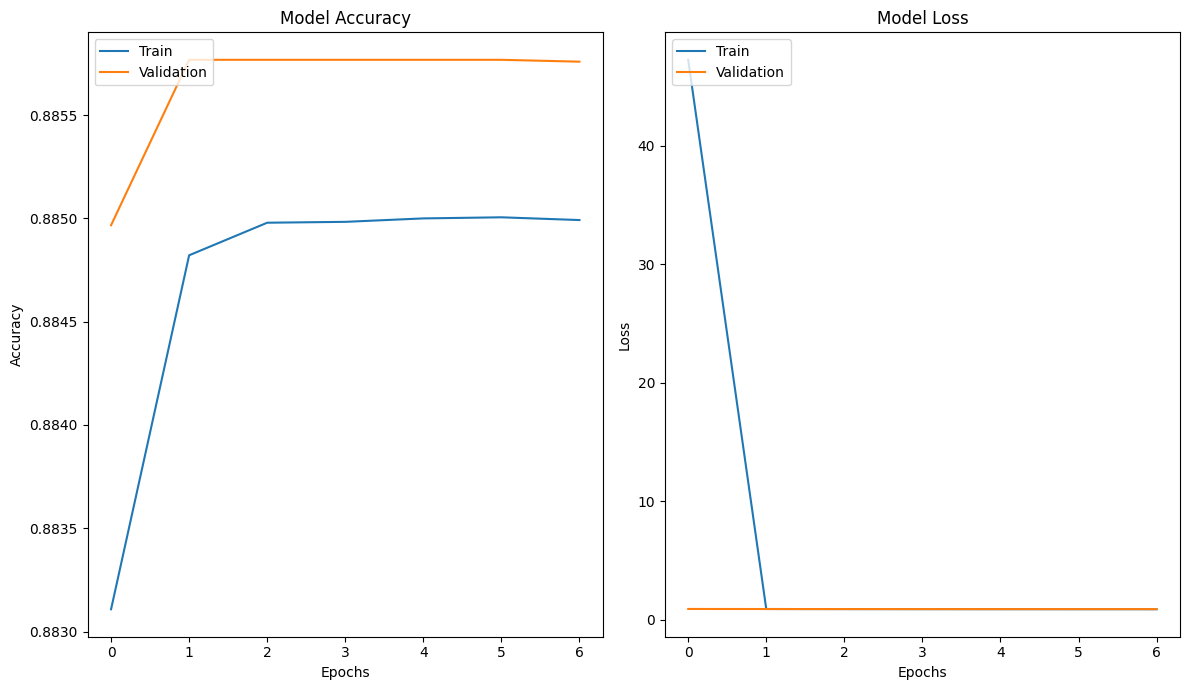

In [52]:
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'],loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'],loc = 'upper left')

plt.tight_layout()
plt.show()

In [61]:
def predictions(text):

    seq = english_tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq,maxlen=maxlen,padding = 'post')
    
    predicted_arr = np.argmax(model.predict([padded,padded]),axis = -1)

    tokenizied = []
    for i in predicted_arr[0]:

        if i in marathi_tokenizer.index_word:

            tokenizied.append(marathi_tokenizer.index_word[i])
        
        else:

            tokenizied.append(' ')

    return ' '.join(tokenizied)